## Libraries

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')

### XGBoost

### Load data

In [60]:
df_train = pd.read_csv(f'./input/df_final_train_albert-base-v2-cls-ff-mse-0.3456.csv')
df_test = pd.read_csv(f'./input/df_final_test_albert-base-v2-cls-ff-mse-0.3456.csv')

In [61]:
x_train = df_train.drop(['price', 'log_price', 'latitude', 'longitude'], axis = 1)
y_train = df_train['log_price']

x_test = df_test.drop(['price', 'log_price', 'latitude', 'longitude'], axis = 1)
y_test = df_test['log_price']

print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test: {x_test.shape}, {y_test.shape}')

Train: (50394, 69), (50394,)
Test: (12599, 69), (12599,)


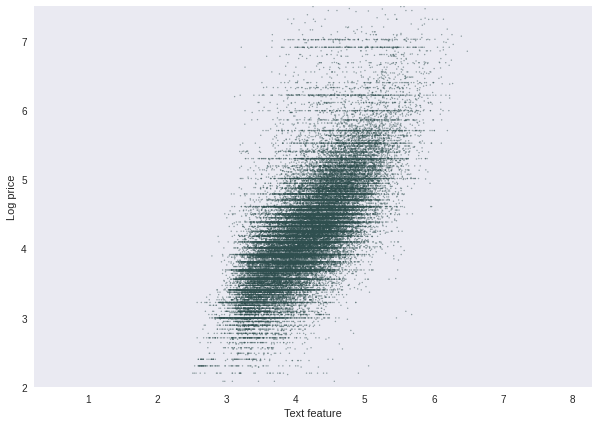

In [96]:
fig = plt.figure(figsize = (10, 7))
plt.scatter(
    df_train['text_feature'],
    df_train['log_price'],
    s = 2,
    alpha = 0.5,
    linewidths = 0,
    edgecolors = 'none',
    color = 'darkslategray'
)
plt.ylabel('Log price')
plt.xlabel('Text feature')
plt.axis('equal')
plt.axis([2, 6.5, 2, 7.5])
plt.grid()
plt.savefig('./output/pricevstext.pdf')
plt.show();

### Hyperparameter tuning

In [62]:
train_xgb = xgb.DMatrix(x_train, label = y_train)
test_xgb = xgb.DMatrix(x_test)

In [58]:
def xgb_func(max_depth, min_child_weight, colsample_bytree, subsample):
    """Returns a 3-fold (stratified) cross-validated AUC for a parameter combination"""
    params = {       
        "max_depth": int(max_depth), 
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "min_child_weight": min_child_weight,
        "gamma": 0,
        "learning_rate": 0.03,
        "verbosity": 0,
        "reg_lambda": 1.2,
        "objective": "reg:squarederror",
        #"tree_method": "gpu_hist",
        "importance_type": "gain",
        "missing": np.nan,
        "seed": 2020
    }        
    cv_result = xgb.cv(
        params,
        train_xgb,
        metrics = ["rmse"],
        num_boost_round = 10_000,
        early_stopping_rounds = 150,
        nfold = 3,
        show_stdv = False,
        verbose_eval = False,
        shuffle = True,
        seed = 2020
    )  
    mse = cv_result["test-rmse-mean"].iloc[-1]**2 # last entry = best iteration
    return mse

In [59]:
param_space = {
    # Model complexity
    "max_depth": (2, 4),
    "min_child_weight": (5, 15),
    # Robustness to noise
    "colsample_bytree": (0.55, 0.85),
    "subsample": (0.55, 0.85)
}

optimizer = BayesianOptimization(
    f = xgb_func,
    pbounds = param_space
)

optimizer.maximize(
    init_points = 3,
    n_iter = 5,
    acq = "ei",
    random_state = 2020
)

|   iter    |  target   | colsam... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------
|  1        |  0.3926   |  0.8498   |  5.211    |  14.31    |  0.734    |
|  2        |  0.4037   |  0.799    |  2.373    |  12.98    |  0.7264   |
|  3        |  0.3964   |  0.6817   |  3.124    |  9.807    |  0.7092   |
|  4        |  0.4038   |  0.7718   |  2.025    |  14.91    |  0.7818   |
|  5        |  0.403    |  0.6365   |  2.001    |  14.65    |  0.7924   |
|  6        |  0.4034   |  0.7961   |  2.016    |  14.85    |  0.8081   |
|  7        |  0.4039   |  0.8398   |  2.01     |  14.59    |  0.7041   |
|  8        |  0.4032   |  0.7388   |  2.008    |  14.93    |  0.8325   |


In [60]:
print(optimizer.max)

{'target': 0.40391933333333335, 'params': {'colsample_bytree': 0.8398360612972067, 'max_depth': 2.0096716344867533, 'min_child_weight': 14.590653622676683, 'subsample': 0.7041126930648678}}


In [ ]:
fig = plt.figure(figsize = (10, 6))
plt.plot(cv_result['test-rmse-mean'])
plt.plot(cv_result['train-rmse-mean'])
plt.grid()
plt.legend(['test', 'train'])
plt.ylim([0, 1.5]);

### Training

In [63]:
colsample_bytree = 0.8 #optimizer.max['params']['colsample_bytree']
max_depth = 2 #optimizer.max['params']['max_depth']
min_child_weight = 14.6 #optimizer.max['params']['min_child_weight']
subsample = 0.7 #optimizer.max['params']['subsample']

params = {       
    "max_depth": int(max_depth),
    "colsample_bytree": colsample_bytree,
    "subsample": subsample,
    "min_child_weight": min_child_weight,
    "gamma": 0,
    "learning_rate": 0.2,
    "verbosity": 1,
    "reg_lambda": 1.2,
    "objective": "reg:squarederror",
    #"tree_method": "gpu_hist",
    "importance_type": "gain",
    "missing": np.nan,
    "seed": 2020
}

model = xgb.train(
    params,
    train_xgb,
    num_boost_round = 2_000,
)

[15:26:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/learner.cc:328: 
Parameters: { importance_type, missing } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




### Evaluation

In [64]:
mean_squared_error(y_train, model.predict(train_xgb))

0.1588754908142655

In [65]:
y_pred = model.predict(test_xgb)
                                               
mean_squared_error(y_test, y_pred)

0.19749913961760027

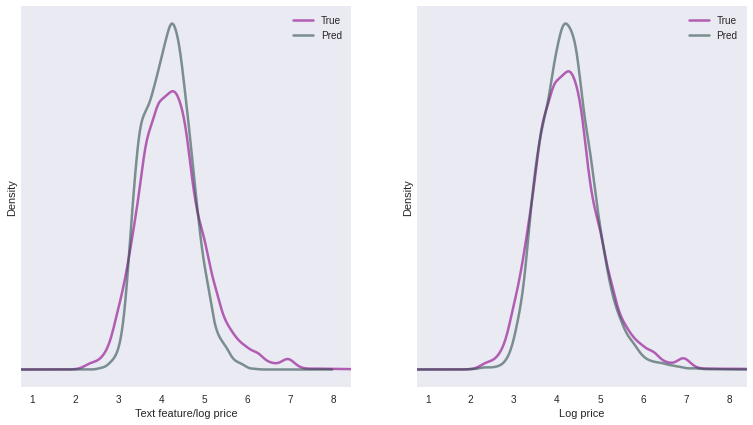

In [103]:
plt.figure(figsize = (13, 7))
plt.subplot(1, 2, 1)
df_test['log_price'].plot(kind = 'density', color = 'darkmagenta', alpha = 0.6, lw = 2.5)
df_test['text_feature'].plot(kind = 'density', color = 'darkslategray', alpha = 0.6, lw = 2.5)
plt.yticks([])
plt.xlim([0.75, 8.4])
plt.ylabel('Density')
plt.xlabel('Text feature/log price')
plt.legend(['True', 'Pred'])
plt.grid()
plt.subplot(1, 2, 2)
pd.Series(y_test).plot(kind = 'density', c = 'darkmagenta', alpha = 0.6, lw = 2.5)
pd.Series(y_pred).plot(kind = 'density', c = 'darkslategray', alpha = 0.6, lw = 2.5)
plt.xlim([0.75, 8.4])
plt.yticks([])
plt.ylabel('Density')
plt.xlabel('Log price')
plt.legend(['True', 'Pred'])
plt.grid()
plt.savefig('./output/gbmpreds.pdf');

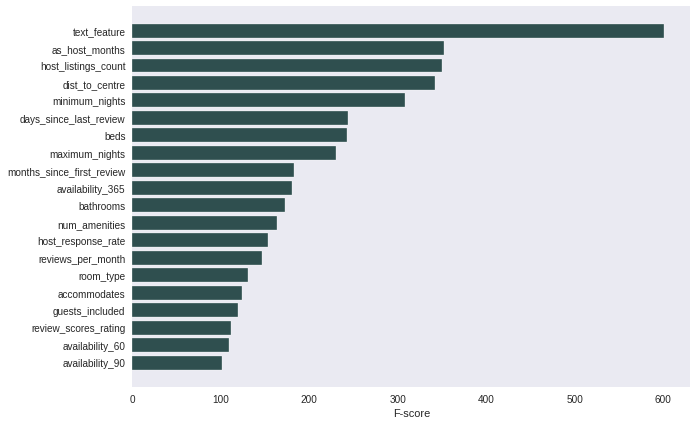

In [95]:
plt.figure(figsize = (10, 7))
imp_df = pd.DataFrame({
    "variables": list(model.get_fscore().keys()),
    "fscores": list(model.get_fscore().values())
})
imp_df = imp_df.sort_values("fscores", ascending = False)
imp_df = imp_df[0:20]
imp_df = imp_df.sort_values("fscores", ascending = True)
plt.barh(imp_df['variables'], imp_df['fscores'], color = 'darkslategray')
plt.xlabel("F-score")
plt.ylabel("")
plt.grid()
plt.savefig('./output/gbmfeatimp.pdf')
plt.show();

## OLS

In [50]:
df_train = pd.read_csv(f'./input/df_final_train_albert-base-v2-cls-ff-mse-0.3456.csv')
df_test = pd.read_csv(f'./input/df_final_test_albert-base-v2-cls-ff-mse-0.3456.csv')

In [51]:
x_train = df_train.drop(['price', 'log_price', 'latitude', 'longitude', 'text_feature'], axis = 1)
y_train = df_train['log_price']

x_test = df_test.drop(['price', 'log_price', 'latitude', 'longitude', 'text_feature'], axis = 1)
y_test = df_test['log_price']

x_cols = x_train.columns

print(f'Train: {x_train.shape}, {y_train.shape}')
print(f'Test: {x_test.shape}, {y_test.shape}')

Train: (50394, 68), (50394,)
Test: (12599, 68), (12599,)


In [52]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

imputer.fit(x_train)

x_train = imputer.transform(x_train)
x_test = imputer.transform(x_test)

In [53]:
x_train = pd.DataFrame(x_train)
x_train.columns = x_cols
x_test = pd.DataFrame(x_test)
x_test.columns = x_cols

train = pd.concat([y_train, x_train], axis = 1)
test = pd.concat([y_test, x_test], axis = 1)

train.to_csv('./input/train_R.csv', index = False)
test.to_csv('./input/train_R.csv', index = False)

## Sample mean prediction

In [26]:
np.round_(mean_squared_error(y_train, [np.mean(y_train)]*len(y_train)), 4)

0.605

In [27]:
np.round_(mean_squared_error(y_test, [np.mean(y_train)]*len(y_test)), 4)

0.6126